In [160]:
cd ..

/Users/lfinkbeiner/Documents/GitHub/AY121/lab2


In [161]:
%run synthesis

In [162]:
cd analyses

/Users/lfinkbeiner/Documents/GitHub/AY121/lab2/analyses


In [58]:
results = load_saves('../data/calibrator.npz')
results

{'cal_on_median': array([6.04529657e+13, 3.46461871e+10, 2.53879609e+10, ...,
        2.47789582e+10, 2.58308291e+10, 3.53930846e+10]),
 'cal_off_median': array([5.96926399e+13, 3.38740619e+10, 2.48433680e+10, ...,
        2.41342222e+10, 2.52149751e+10, 3.44630277e+10]),
 'cal_on_mean': array([6.06161856e+13, 4.94497090e+10, 3.72847430e+10, ...,
        3.61482422e+10, 3.66009026e+10, 4.94172222e+10]),
 'cal_off_mean': array([5.97887781e+13, 4.80161996e+10, 3.62799246e+10, ...,
        3.51687860e+10, 3.59561361e+10, 4.86470779e+10]),
 'cass_on_mean': array([5.64272541e+13, 1.29264575e+11, 1.14786276e+11, ...,
        1.15380775e+11, 1.14040955e+11, 1.26834330e+11]),
 'cass_off_mean': array([5.71485205e+13, 1.30973650e+11, 1.18510128e+11, ...,
        1.18080850e+11, 1.16121664e+11, 1.30383611e+11]),
 'hot': array([5.67259742e+13, 2.63871130e+12, 2.11994437e+12, ...,
        2.14079207e+12, 2.74826113e+12, 2.71109659e+12]),
 'cold': array([5.61524302e+13, 1.44665068e+11, 1.02551876e+1

In [59]:
cal_on = results['cal_on_mean']
cal_off = results['cal_off_mean']
cass_on = results['cass_on_mean']
cass_off = results['cass_off_mean']
hot = results['hot']
cold = results['cold']

In [60]:
G = gain(hot, cold)

In [61]:
x = freq_range(62.5e6 / 6, 16000) / 10 ** 6

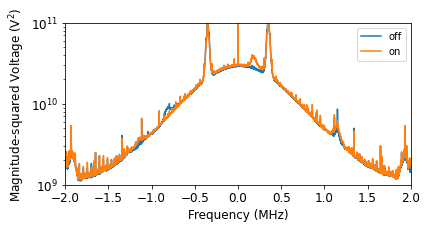

In [64]:
# Here is an example where the y limits are set correctly for a logarithmic plot!
over_pp(x, cal_off, cal_on, 'off', 'on', (-2, 2), (10**9, 10**11),logv=True)

Now we hope to move on to velocity and reference frame.

We observe the line frequency to be about .18 MHz

In [68]:
# .18 MHz is the location of the HI line in this scenario
# Left bound
print(doppler(-2, .18, -0.027923))
# Right bound
print(doppler(2, .18, -0.027923))

3633.3054103333334
-3033.3612563333336


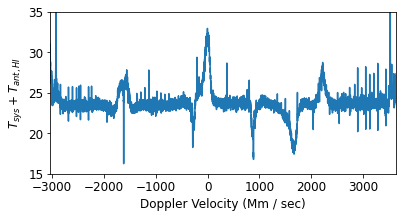

In [77]:
cal_velocities = doppler(x, .18, -0.027923)

pp_skeleton(cal_velocities, G * cal_on / cal_off,
            xBounds = (-3033.3612563333336, 3633.3054103333334),
            yBounds = (15, 35),
            xLabel = 'Doppler Velocity (Mm / sec)',
            yLabel = r'$T_{sys} + T_{ant, HI}$')

Declination is equal to latitude, which is equal to 37.873199 degrees.
Right ascension was equal to LST, which at that time was 

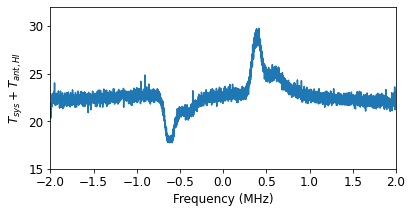

In [75]:
pp_skeleton(x, G * cass_on / cass_off,
            (-2, 2), (15, 32),
           yLabel = r'$T_{sys} + T_{ant, HI}$')

In [76]:
# the HI line is now at .39 MHz
# Left bound
print(doppler(-2, .39, -0.028834))
# Right bound
print(doppler(2, .39, -0.028834))

1838.4327044615384
-1238.4903724615383


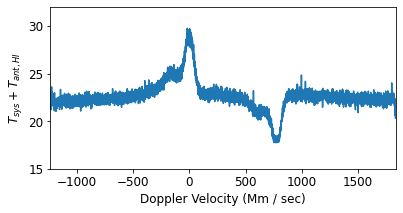

In [78]:
cass_velocities = doppler(x, .39, -0.028834)

pp_skeleton(cass_velocities, G * cass_on / cass_off,
            xBounds = (-1238.4903724615383, 1838.4327044615384),
            yBounds = (15, 32),
            xLabel = 'Doppler Velocity (Mm / sec)',
            yLabel = r'$T_{sys} + T_{ant, HI}$')

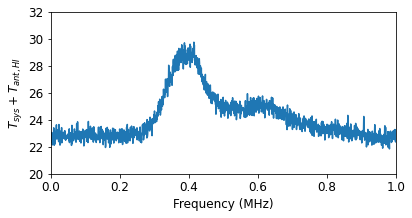

In [140]:
# This would be my justification if I were asked,
# "why did you not perform a subtractive polyfit?"
pp_skeleton(x, G * cass_on / cass_off,
            (0, 1), (20, 32),
           yLabel = r'$T_{sys} + T_{ant, HI}$')
# 'Looks pretty flat to me

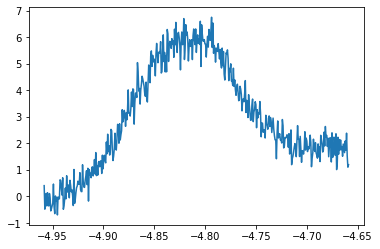

In [141]:
#.25 to .55, roughly
gauss1x = x[384:845]
gauss1yt = G * cass_on / cass_off
plt.plot(gauss1x, gauss1yt[384:845] - 23)

In [142]:
fit1 = ugradio.gauss.gaussfit(gauss1x, gauss1yt[384:845] - 23, 6, -4.82, .3)
fit1

{'amp': array([5.78894617]),
 'avg': array([-4.80763112]),
 'sig': array([0.06106914])}

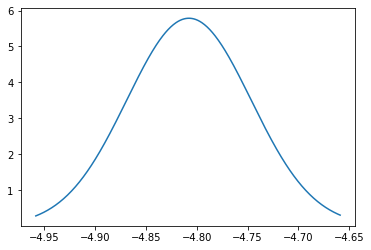

In [143]:
#.25 to .55, roughly
gauss1g = ugradio.gauss.gaussval(gauss1x, 5.78579018, -4.80764434, .06114922)
plt.plot(gauss1x, gauss1g)
# it's important to keep in mind the constant offset of 23
fit1['off'] = 23

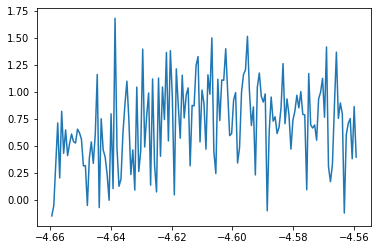

In [144]:
#.549 to .65, roughly
gauss2x = x[843:998]
gauss2yt = G * cass_on / cass_off
plt.plot(gauss2x, gauss2yt[843:998] - 24.25)

In [145]:
fit2 = ugradio.gauss.gaussfit(gauss2x, gauss1yt[843:998] - 24.25, 1.5, -4.6, .04)
fit2

{'amp': array([0.89061876]),
 'avg': array([-4.5983087]),
 'sig': array([0.04334641])}

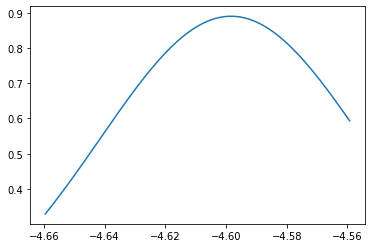

In [146]:
#.25 to .55, roughly
gauss2g = ugradio.gauss.gaussval(gauss2x, fit2['amp'], fit2['avg'], fit2['sig'])
plt.plot(gauss2x, gauss2g)
# it's important to keep in mind the constant offset of 24.25
fit2['off'] = 24.25

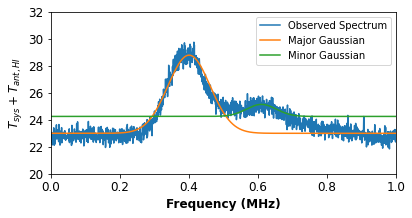

In [163]:
# This will be bad for two reasons
    # 1. each Gaussian needs a constant vertical offset
    # 2. the fftshift might eviscerate the structure fo the Gaussians
tau_cannon(x, G * cass_on / cass_off,
           fit1, fit2,
            (0, 1), (20, 32))
           